In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0,'/home/pawel1/Pulpit/Astrophysics/CTA/soft/ctapipe_io_lst')
sys.path.insert(0, '/home/pawel1/Pulpit/Astrophysics/CTA/cta-lstchain')

from ctapipe_io_lst import LSTEventSource
from traitlets.config.loader import Config 


from lstchain.calib.camera.r0 import LSTR0Corrections

from tools import get_first_capacitor
from time_cal_corr import TimeCalCorr

In [2]:
class SimpleExtractor:
    pass

def extract_pulse_time(waveforms):
    peak = waveforms.argmax(1)
    start = peak - window_shift
    end = start + window_width
    ind = np.indices(waveforms.shape)[1]
    integration_window = ((ind >= start[..., np.newaxis]) &
                        (ind < end[..., np.newaxis]))
    samples_i = np.indices(waveforms.shape)[1]
    pulse_time = np.average(samples_i, weights=waveforms*integration_window, axis=1)
    outside = np.logical_or(pulse_time < 0, pulse_time >= waveforms.shape[1])
    pulse_time[outside] = -1
    return pulse_time

pulse_time: 18.32092037541629


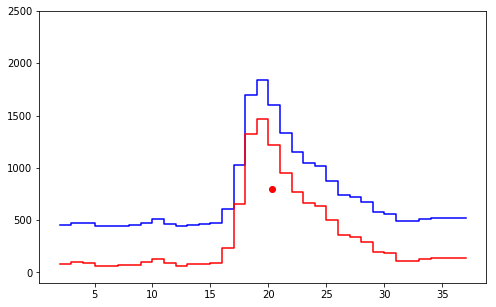

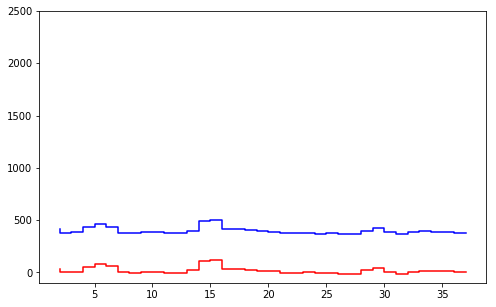

pulse_time: 22.586871165644173


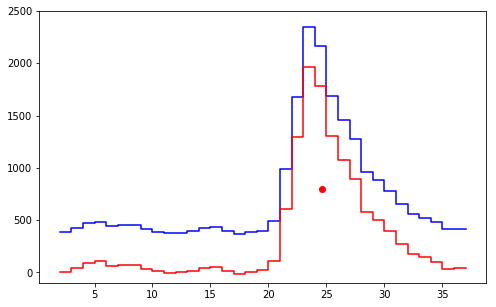

pulse_time: 22.42286234771718


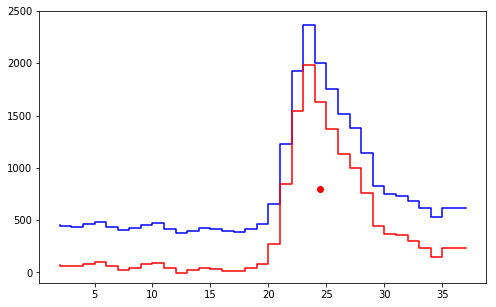

pulse_time: 23.162328607947945


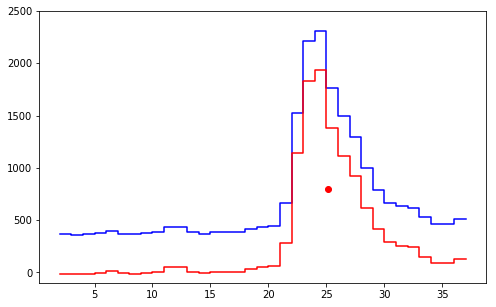

pulse_time: 23.163648928818244


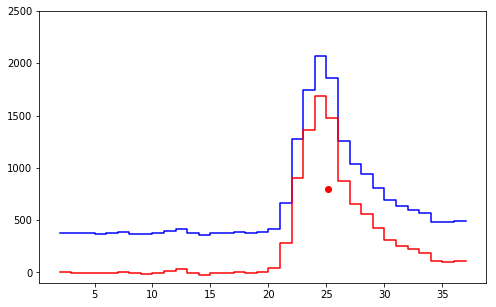

pulse_time: 25.011978479342197


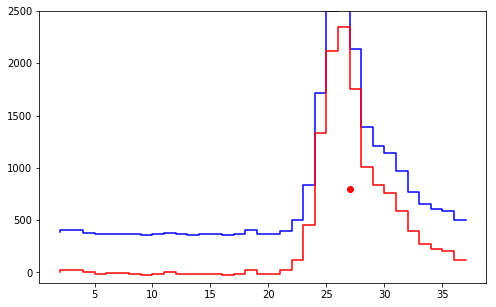

pulse_time: 25.327443609022556


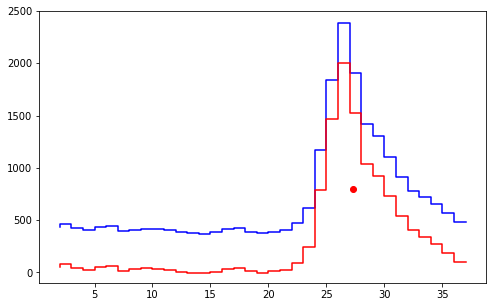

pulse_time: 22.9716880972042


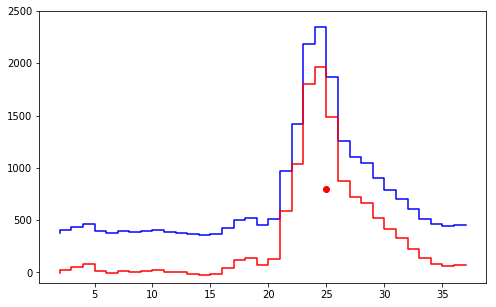

pulse_time: 23.091994290904374


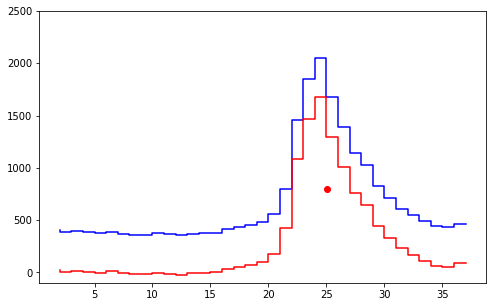

pulse_time: 23.98600834118122


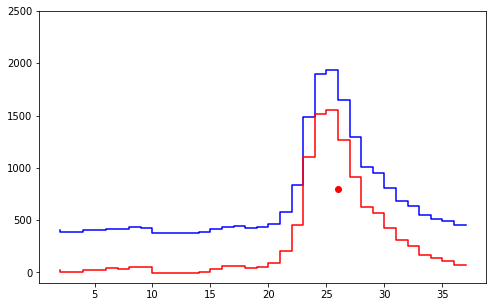

pulse_time: 23.453891432308698


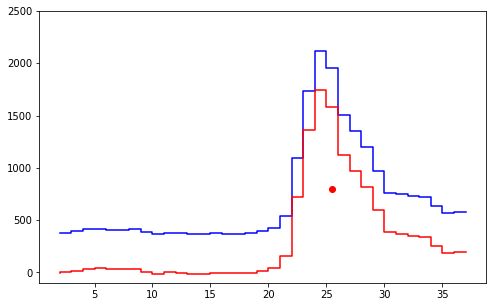

pulse_time: 22.667481662591687


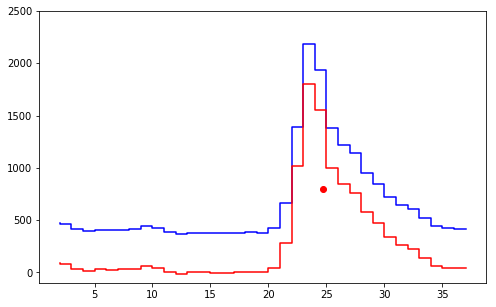

pulse_time: 24.085842148087877


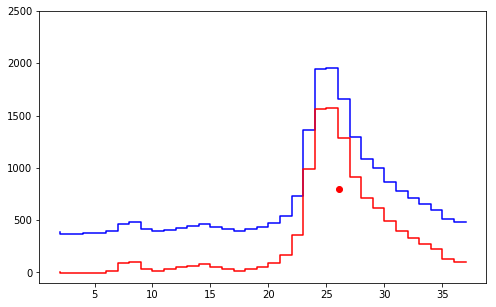

pulse_time: 22.712922362651536


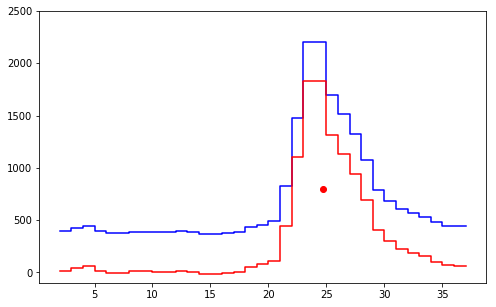

pulse_time: 25.02122432937015


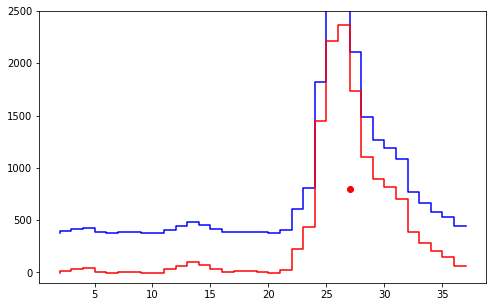

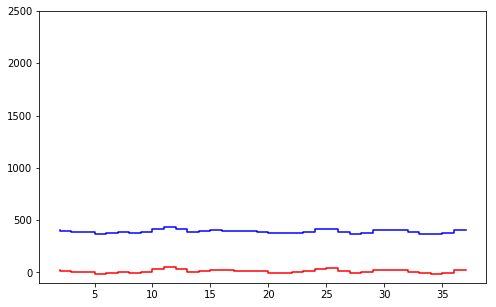

pulse_time: 24.0643294758339


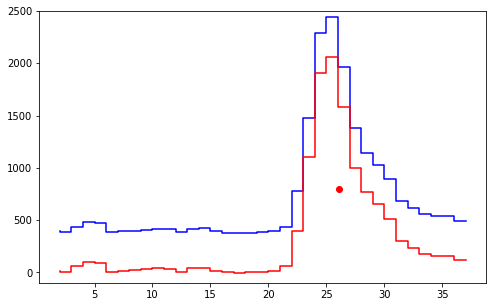

pulse_time: 22.92591629841435


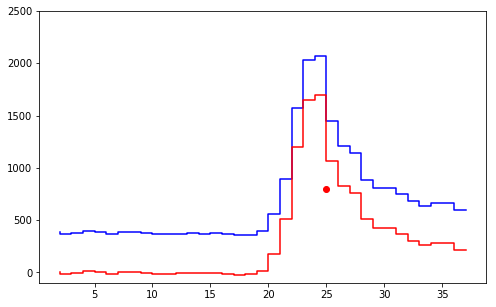

pulse_time: 24.200070406007978


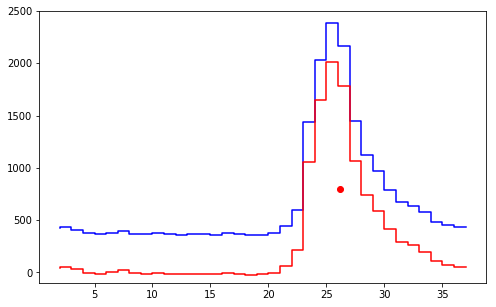

pulse_time: 23.549266247379453


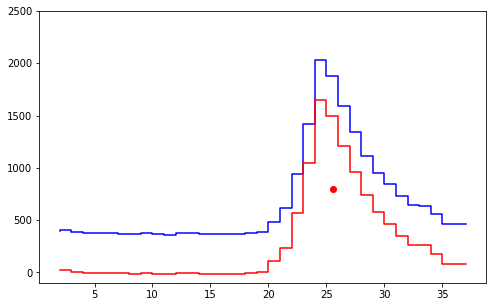

pulse_time: 21.511133603238868


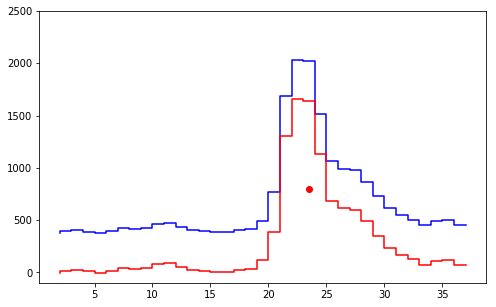

pulse_time: 24.056749884419787


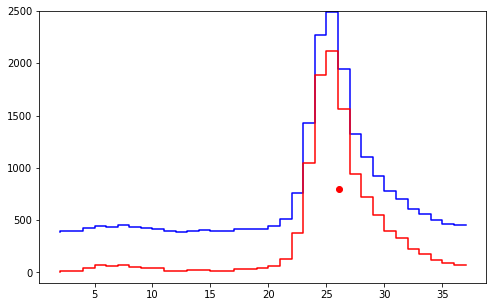

pulse_time: 23.185978209379442


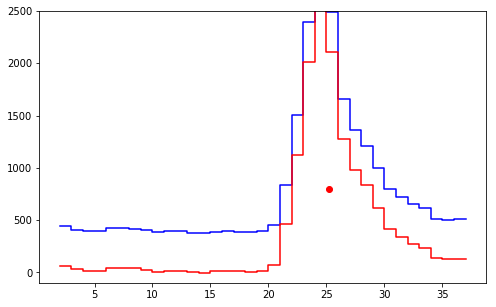

pulse_time: 21.34528344163119


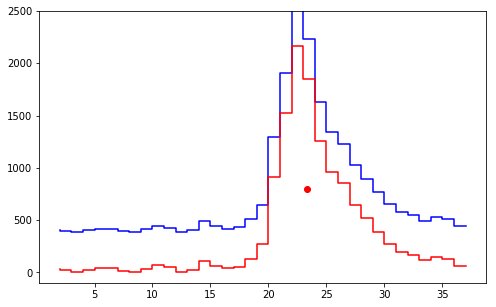

In [7]:
input_file_1 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00250.0000.fits.fz"

config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": "/media/pawel1/ADATA HD330/20190215/pedestal_run97_new.fits",
        "offset":  400,
        "tel_id": 0
    }
})


reader = LSTEventSource(input_url=input_file_1, max_events=25)
lst_r0 = LSTR0Corrections(config=config_corr)
pixel = 1854
window_shift = 3
window_width = 7

t = np.linspace(2, 37, 36)
for i, ev in enumerate(reader):
    lst_r0.calibrate(ev)
    plt.figure(figsize=(8, 5))
    plt.step(t,  ev.r1.tel[0].waveform[0, pixel, 2:38], color="blue")
    plt.ylim([-100, 2500])
    
    baseline_subtracted = ev.r1.tel[0].waveform[:, :, 2:38] - 380
    plt.step(t,  baseline_subtracted[0, pixel, :], color="red")
    try:
        pulse_time = extract_pulse_time(baseline_subtracted[0, :, :])
        if np.max(baseline_subtracted[0, pixel, :]) > 1000: 
            plt.plot(pulse_time[pixel]+2, 800, 'ro')
            print("pulse_time: {}".format(pulse_time[pixel]))
    except Exception as err:
        print(err)
    
    
    plt.show()

In [64]:
input_file_1 = "/media/pawel1/ADATA HD330/20190226/LST-1.*.Run00170.0000.fits.fz"
reader = LSTEventSource(input_url=input_file_1, max_events=4000)
lst_r0 = LSTR0Corrections(config=config_corr)

nr = 100
pix = 2

n_combine = 8
n_harm = 16
n_cap = 1024
n = int(n_cap/n_combine)
timeCorr = TimeCalCorr(n_combine, n_harm, n_cap)

for ev in reader:
    if ev.r0.event_id%200 == 0:
        print(ev.r0.event_id)
    lst_r0.subtract_pedestal(ev)
    
    expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
    fc = get_first_capacitor(ev, nr)
    pixel = expected_pixel_id[nr * 7 + pix]
    
    baseline_subtracted = ev.r1.tel[0].waveform[:, :, 2:38] - 380

    try:
        pulse_time = extract_pulse_time(baseline_subtracted[0, :, 2:38])
        if np.max(baseline_subtracted[0, pixel, :]) > 1000: 
            timeCorr.fill(fc[0, pix]%1024, pulse_time[0])
    except Exception as err:
        print(err)    
timeCorr.finalize()

200
400
600
800
Weights sum to zero, can't be normalized
1000
1200
1400
1600
Weights sum to zero, can't be normalized
1800
2000
2200
Weights sum to zero, can't be normalized
2400
2600
2800
Weights sum to zero, can't be normalized
3000
Weights sum to zero, can't be normalized
3200
3400
3600
3800
4000


Text(0.5,1,'n_harm = 16, pixel = 312')

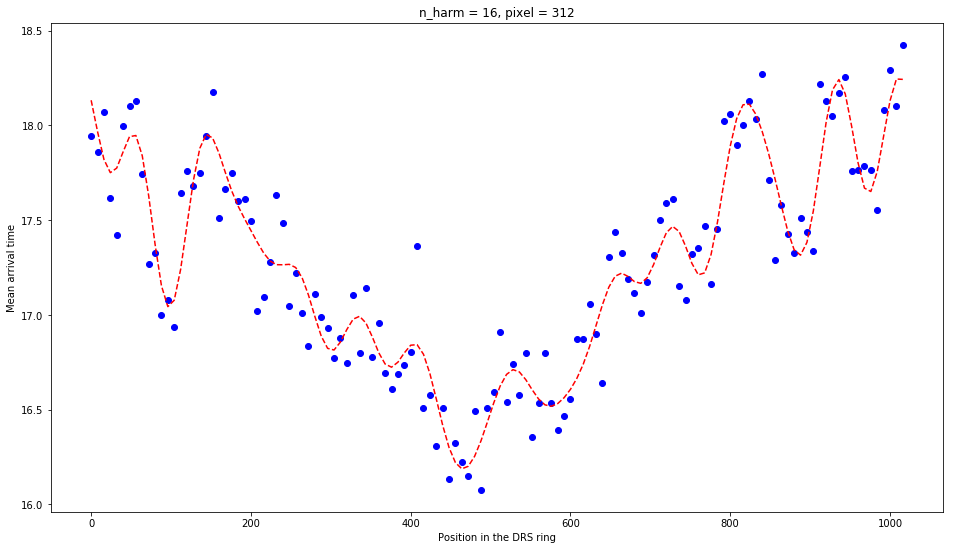

In [65]:
fc = np.arange(0, 1024, n_combine)
an = timeCorr.fan
bn = timeCorr.fbn
y = np.zeros(n)

for i in range(0, len(y)):
    temp_cos = an[0]/2
    temp_sin = 0
    for j in range(1, len(an)):
        temp_cos += an[j] * np.cos(2 * j * np.pi * (fc[i] / 1024.)) 
        temp_sin += bn[j] * np.sin(2 * j * np.pi * (fc[i] / 1024.))
    y[i] = (temp_cos + temp_sin)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(np.arange(0, 1024, n_combine), timeCorr.fMeanVal, 'bo')
ax.plot(fc, y, 'r--')
ax.set_ylabel("Mean arrival time")
ax.set_xlabel("Position in the DRS ring")
ax.set_title("n_harm = {}, pixel = {}".format(n_harm, pixel))

In [70]:
input_file_2 = "/media/pawel1/ADATA HD330/20190226/LST-1.2.Run00170.0001.fits.fz"
reader = LSTEventSource(input_url=input_file_2, max_events=5000)
lst_r0 = LSTR0Corrections(config=config_corr)

arrival_time_list = [] 
arrival_time_corr_list = []


for ev in reader:
    if ev.r0.event_id%200 == 0:
        print(ev.r0.event_id)
        
    lst_r0.subtract_pedestal(ev)
    
    expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
    fc = get_first_capacitor(ev, nr)
    pixel = expected_pixel_id[nr * 7 + pix]
    
    baseline_subtracted = ev.r1.tel[0].waveform[:, :, 2:38] - 380
        
    try:
        pulse_time = extract_pulse_time(baseline_subtracted[0, :, 2:38])
        if np.max(baseline_subtracted[0, pixel, :]) > 1000: 
            arrival_time_list.append(pulse_time[0])
            arrival_time_corr_list.append(timeCorr.get_corr_time(fc[0, pix]%1024))
    except Exception as err:
        print(err)  

Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized
Weights sum to zero, can't be normalized


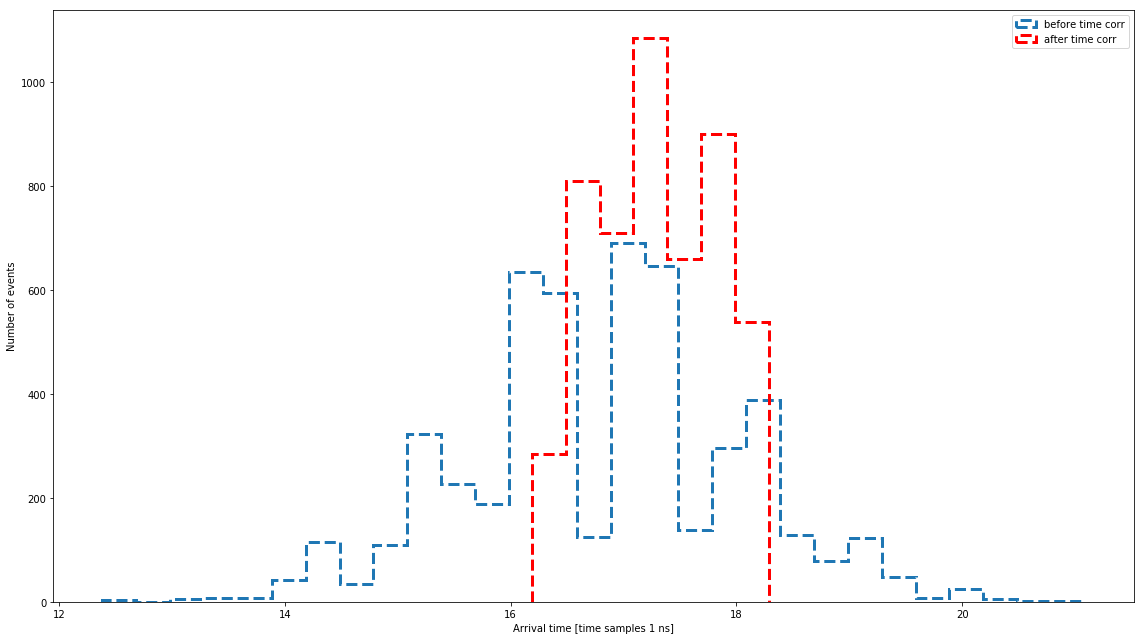

In [75]:
plt.figure(figsize=(16, 9))
binwidth = 0.3
plt.hist(arrival_time_list, histtype='step', lw=3, linestyle='--', range=(20,30),
        bins=np.arange(min(arrival_time_list), max(arrival_time_list) + binwidth, binwidth),
        label="before time corr")

plt.hist(arrival_time_corr_list, histtype='step', lw=3, linestyle='--', color='red', range=(20, 30),
         bins=np.arange(min(arrival_time_corr_list), max(arrival_time_corr_list) + binwidth, binwidth),
        label="after time corr")
plt.ylabel("Number of events")
plt.xlabel("Arrival time [time samples 1 ns]")
plt.legend()
plt.tight_layout()
#plt.yscale('log')
plt.show()

In [72]:
print(np.std(arrival_time_list))
print(np.std(arrival_time_corr_list))

1.193044600097666
0.5398621751814334
